## Instructions
- See deadline on the course web page
- This problem set is solved individually. See examination rules on the course web page and the explanation of the examination procedure below.
- The two notebooks for each problem set contain a number of basic and extra problems; you can choose which and how many to work on. The extra problems are usually more challenging.
- Students are allowed to discuss together and help each other when solving the problems. However, every student must understand their submitted solution in the sense that they should be able to explain and discuss them with a peer or with a teacher.
- While discussions with your peers are allowed (and even encouraged), direct plagiarism is not. Every student must reach their own understanding of submitted solutions according to the definition in the previous point.
- The use of coding assistance from code generating artificial intelligence tools is allowed. However, every student must reach their own understanding of submitted solutions (including employed algorithms) according to the definition above.
- Some problems include checkpoints in the form of `assert` statements. These usually check some basic functionality and you should make sure that your code passes these statements without raising an `AssertionError`. 
- Do not use other python modules than the ones included in the `environment.yml` file in the course github repo. 

- **Important:** The grading of problem sets requires **all** of the following actions:
  1. Make sure to always complete **Task 0** in the header part of the notebook and that this part does not raise any `AssertionError`(s).
  1. **Complete** the corresponding questions in Yata for every task that you have completed. This usually involves copying and pasting some code from your solution notebook and passing the code tests. You need to have a green check mark on Yata to get the corresponding points.
  1. **Upload** your solution in the form of your edited version of this Jupyter notebook via the appropriate assignment module in Canvas (separate for basic and extra tasks). It is the code and results in your submitted notebook that is considered to be your hand-in solution.
  1. If selected, be **available for a discussion** of your solution with one of the teachers on the Monday afternoon exercise session directly following the problem set deadline. No extra preparation is needed for these discussions apart from familiarity with your own solution. A list of randomly selected students will be published on the course web page around Monday noon. During the afternoon session that same day, students will be called in the numbered order until the end of the list (or the end of the exercise session). You must inform the responsible teacher as soon as possible following the publication of the student list if you can not be physically present at the exercise session (in which case we will have the discussion on zoom). An oral examination (on all aspects of the course) will be arranged during the exam week for students that do not show up for their discussion slot, or that fail to demonstrate familiarity with their hand-in solutions.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

- Make sure that the **run time is smaller than a few minutes**. If needed you might have to reduce some computational tasks; e.g. by decreasing the number of grid points or sampling steps. Please ask the supervisors if you are uncertain about the run time. 

- Your solutions are usually expected where it says `YOUR CODE HERE` or <font color="red">"PLEASE WRITE YOUR ANSWER HERE"</font>.

### Task 0 
#### (0 points)

By changing the below boolean variable `student_self_assessment` to `True` you attest that:
- All handed in solutions were produced by yourself in the sense that you understand your solutions and should be able to explain and discuss them with a peer or with a teacher.


In [1]:
student_self_assessment = False

# 
# YOUR CODE HERE
# 
student_self_assessment = True

In [2]:
assert student_self_assessment == True, 'You must assert the individual solution statements.'

# Problem Set 3 (Extra problems)
### Learning from data [TIF285], Chalmers, Fall 2025

Last revised: 29-Sep-2025 by Christian Forssén [christian.forssen@chalmers.se]

In [3]:
import os
# Data files are stored in
DATA_DIR = "DataFiles/"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

## Problem 5: Bayesian optimization (3 points)
*You should have solved problem 3 to get some acquaintance with Gaussian Processes before doing this problem.*

In [5]:
# 
# YOUR CODE HERE
# 
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats as stats
import pandas as pd
import emcee as emcee

### A univariate minimization problem

Try to minimize the function
$$
f(x) = \sin(6 x) + 0.2 x^2 - 0.7 x
$$
on the interval $x \in [-5,5]$.

The aim is to find the position of the minimum $x^*$ to within $\pm 0.05$ under the constraint that we would like to make as few function evaluations as possible.

### Plot the true function

a. **Plot the true function and indicate the position of the minimum**
Save the position of the *global* minimum in the variable `xtrue_min` (with at least two significant decimals)

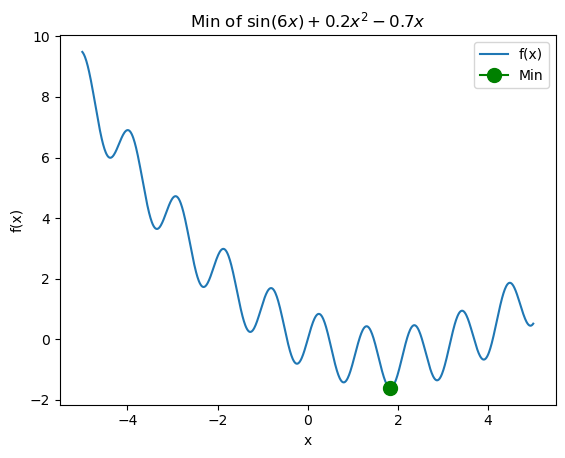

In [12]:
xmin =  -5.
xmax =  5.
X_domain = np.linspace(xmin,xmax,1000)

# 
# YOUR CODE HERE
# 
def f(x):
    y = np.sin(6*x) + 0.2*x**2 - 0.7*x
    return y

argmin = np.argmin(f(X_domain))
xtrue_min = X_domain[argmin]
plt.plot(X_domain, f(X_domain), label='f(x)')
plt.plot(xtrue_min, f(xtrue_min), marker='o', markersize=10, color='green', label='Min')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Min of $\sin(6x) + 0.2x^2 - 0.7x$') 
plt.legend()
plt.show()

### Build your own BayesOpt algorithm

You will now implement a very different approach to minimize an objective function (this is a conventional name for the function that we are trying to minimize or maximize). The approach is known as **Bayesian optimization** and the basic idea is the following:
* Select a few random points, evaluate the unknown function at these samples and build a **Gaussian Process regression model** for the function output in the entire input range based on this data.
* Make a decision which point to sample next based on a so called **acquisition function** evaluated from the GP model. This decision will incorporate our current knowledge about the function including our uncertainty for its value in different regions.
* Improve the statistical model using the new sample. Continue sampling new points according to the acquisition function.
* If done correctly, this approach will balance **exploration** of new regions (with uncertain outputs, that might contain the minimum) and **exploitation** of the region that is currently most promising.
* Very importantly, this method also works when you are dealing with **noisy objective functions**, i.e. when your "measurement" of its value at a new point in parameter space contains some random noise.

Your task is to repeat the above minimization with **your own Bayesian Optimization algorithm**, that should be assembled as described below. Bayesian optimization algoritms are built into libraries such as `Scikit-optimize` and `GPyOpt`, but we will build our own simple version using functions from `numpy`, `scipy`, and `sklearn` (for building the statistical model).

The pseudo-code for BayesOpt is the following (see specific hints for your implementation at the end):
1. pick starting points $\mathbf{x}^{(1)},\mathbf{x}^{(2)},\ldots \mathbf{x}^{(k)}$, where $k \geq 2$
1. evaluate the objective function $f(\mathbf{x})$ to obtain $y^{(i)}=f(\mathbf{x}^{(i)})$ for $i=1,\ldots,k$
1. initialize a data vector $\mathcal{D}_k = \left\{(\mathbf{x}^{(i)},y^{(i)})\right\}_{i=1}^k$
1. select a statistical model for $f(\mathbf{x})$
1. **For** {$n=k+1,k+2,\ldots$}
   1.    select $\mathbf{x}^{(n)}$ by optimizing the acquisition function: $\mathbf{x}^{(n)} = \underset{\mathbf{x}}{\text{arg max}}\, \mathcal{A}(\mathbf{x}|\mathcal{D}_{n-1})$
   1.    evaluate the objective function to obtain $y^{(n)}=f(\mathbf{x}^{(n)})$
   1.    augment the data vector $\mathcal{D}_n = \left\{\mathcal{D}_{n-1} , (\mathbf{x}^{(n)},y^{(n)})\right\}$
   1.    update the statistical model for $f(\mathbf{x})$
1. **end for**

   Check for the minimum in the data vector that has been collected (note that it doesn't necessarily have to be the last sample).


**Hints:**
* You have to implement all steps in the above pseudo-code.
* You can try with $k=2$ starting points.
* For the statistical model you can use a GP implemented with `sklearn.gaussian_process`. Follow the examples from the lectures and the demonstration notebook.
* Any knowledge about the objective function should be built into the covariance function. Let us assume that we don't have much information and that we use a standard RBF kernel.
* It is recommended to constrain the RBF lengthscale so that it doesn't become unrealistic small. With `sklearn.gaussian_process`, such a constraint on the RBF kernel correlation length can be imposed using `kernels.RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.))`.
* Implement the so called Lower Confidence Bound (LCB) acquisition function for use in step 5A. Then, the acquisition function is simply: $\mathcal{A}(\boldsymbol{x}; | \mathcal{D}_{n-1}) = -\mu(\boldsymbol{x}) + \beta \sigma(\boldsymbol{x})$, where
  * $\mu(\boldsymbol{x})$ is the mean of the GP model trained with the data $\mathcal{D}_{n-1})$.
  * $\sigma(\boldsymbol{x})$ is the standard deviation of the GP model trained with the data $\mathcal{D}_{n-1})$.
  * $\beta$ is another hyperparameter for tuning the preference for exploring unknown regions. You can set $\beta = 3$.
* Remember that the GP model has to be updated (the hyperparameters re-optimized) at step 5D.
* It is possible that you get warnings during the optimization step. In any case, you might want to set `n_restarts_optimizer`to a number larger than 0 as the optimization of GP hyperparameters might be challenging.

**Tasks**
* Implement the BayesOpt minimizer
* Assume that you are allowed a total of 100 function evaluations ($k$ of them for the starting points and $100-k$ in the loop). Are you able to find the minimum to within $\pm 0.05$?
* Plot the final statistical model together with the true function. Show which points that have been explored.
* Plot also the convergence of the minimum value $\min(y_n)$ as a function of the iteration number $n \in \{1, \ldots, 100\}$. How many iterations do you need to find the minimum?

In [ ]:
# Initialize the Bayesian Optimization by performing steps 1-4.
# You might want to try with different seeds.
#
# 
# YOUR CODE HERE
# 

In [ ]:
# You can use the utility function for plotting a GP prediction with credible interval from the basic problem 3.

# 
# YOUR CODE HERE
# 

In [ ]:
# Perform the loop, i.e. repeat steps 5A-D 100-k times
#
# For better performance of the BayesOptimizer it is desirable to shift the grid in each iteration
npoints=1000
xrange=xmax-xmin
dx=xrange/npoints
X_domain = np.linspace(xmin+dx*np.random.uniform(),xmax,10000).reshape(-1,1)

#
# 
# YOUR CODE HERE
# 

In [ ]:
# Print the final result. Did you find the minimum to within 0.05?
# Print also the hyperparameters of the final statistical model
#
# Make three plots: 
# 1. The statistical model after the final sample.
#    Show which points that have been sampled during the run.
# 2. The acquisition function after the final sample.
# 3. The minimum function output as a function of the iteration number.
#    (i.e. what is the "best" output that has been found so far?)  
#    Compare to the true minimum of f(x)
#
#
# 
# YOUR CODE HERE
# 

In [ ]:
# 
# YOUR CODE HERE
# 

## Problem 6: A simple Bayesian binary classifier (4 points)
*You should have solved problem 4 before doing this problem.*

In [13]:
# Import modules
#
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# Additional module import statements if needed
# 
# YOUR CODE HERE
# 

Create a bayesian binary classifier that can take $(E,|m|)$ as input data and predicts a binary label (0=below $T_c$, 1=above $T_c$). 
* Use only high- and low-tempterature data for training (so that predictions for intermediate temperature data should be more difficult). Use normalized data as in Task 4.
* The weights (and bias) of the single neuron binary classifier will be described by pdf:s that we will sample from using MCMC.
* Use a Gaussian prior on the two weights and the bias (with ``weight decay'' $\sigma = 1.0)$.
* Construct the (log) likelihood as in logistic regression. 
* Use, e.g., `emcee`, for the MCMC sampling.
* The prediction for a given input should be characterized by a pdf; i.e. the predicted probability for the state belonging to class 1 (above $T_c$) will itself be described by a pdf.

**Sub-tasks**

(a) Set up the training data

(b) Train the Bayesian binary classifier and plot the pdf:s for the weights and bias.

(c) Plot the decision boundaries for a few samples of the Bayesian binary classifier. Translate to an average decision boundary.

(d) Study in particular the **prediction** of your Bayesian binary classifier for inputs $(E,|m|)$ that corresponds to:
1. low-temperature configurations.
1. high-temperature configurations.
1. temperatures very close to the critical one.

Make a plot, or sequence of plots, to visualize your findings.

In [ ]:
# Read data
T, Es, Ms = np.loadtxt(f'{DATA_DIR}/PS3_Prob4_data.txt',unpack=True)

input_data = np.column_stack((Es,Ms))

Tc = 2 / np.log(1+np.sqrt(2))
high_T = T>Tc

# High-temperature = 1
targets = high_T*np.ones_like(T,dtype=int)

**Subtask (a)**: Set up the training data
- Normalize the input data (mean=0, stddev=1)
- Use high- (T>3.5) and low-temperature (T<1.5) data for training. 
- Plot the training data, indicate the target output 1: T>Tc with red symbols and 0: T<Tc with blue symbols.


In [ ]:
# 
# YOUR CODE HERE
# 

In [ ]:
# Single neuron classifier code from Problem 4 is probably needed to implement the Bayesian neuron

def sigmoid(a):
    # 
    # YOUR CODE HERE
    # 

def single_neuron(x, w):
    """
    Single neuron prediction. 
    Column in the input x is the bias.
    
    Args:
        x (array[float]): input to the neuron
        w (array[float]):

    Returns:
        y (float): the output of the neuron
    """
    # 
    # YOUR CODE HERE
    # 

In [ ]:
# Define the log prior, likelihood, posterior
#
# 
# YOUR CODE HERE
# 

**Sub-task (b)**: Train the Bayesian binary classifier and plot the pdf:s for the weights and bias.

In [ ]:
# 
# YOUR CODE HERE
# 

**Sub-task (c)**: Plot the decision boundaries for a few samples of the Bayesian binary classifier. Translate to an average decision boundary.

In [ ]:
# 
# YOUR CODE HERE
# 

**Sub-task (d)**: Study in particular the **prediction** of your Bayesian binary classifier for inputs $(E,|m|)$ that corresponds to:
1. low-temperature configurations.
1. high-temperature configurations.
1. temperatures very close to the critical one.

Make a plot, or sequence of plots, to visualize your findings.

In [ ]:
# 
# YOUR CODE HERE
# 